In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

SEED = 42
plt.style.use("ggplot")
pd.options.display.max_columns = None

In [2]:
# Chargeaons les données pré-traitées
train_df = pd.read_csv("train_pre.csv")
test_df = pd.read_csv("test_pre.csv")

In [3]:
train_df.head()

,id,dur,proto,service,sbytes,dbytes,rate,sload,dload,sinpkt,dinpkt,sjit,djit,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,response_body_len,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat
0,1,0.002025,90,12,0.000018,0.000012,0.000074,2.364553e-06,0.000379,0.000288,0.000148,0.000021,0.000041,0.144768,0.512828,0.000000,0.000000,0.000000,0.010163,0.029492,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.000000,Normal
1,2,0.010832,90,12,0.000054,0.002867,0.000078,1.401989e-06,0.022458,0.000592,0.000272,0.000042,0.004796,0.330128,0.716524,0.000000,0.000000,0.000000,0.016260,0.758573,0.0,0.677419,0.00,0.00,0.0,0.015625,0.000000,0.081967,Normal
2,3,0.027052,90,12,0.000026,0.000900,0.000014,2.625704e-07,0.002717,0.002748,0.001811,0.011763,0.039466,0.492706,0.689918,0.044423,0.029261,0.033164,0.012195,0.565158,0.0,0.096774,0.02,0.00,0.0,0.031250,0.016949,0.081967,Normal
3,4,0.028027,90,2,0.000046,0.000053,0.000014,4.576117e-07,0.000150,0.001812,0.001591,0.000177,0.017249,0.257772,0.243882,0.000000,0.000000,0.000000,0.016260,0.043896,0.0,0.000000,0.02,0.00,0.0,0.031250,0.016949,0.000000,Normal
4,5,0.007491,90,12,0.000039,0.000018,0.000033,1.429776e-06,0.000178,0.000566,0.001334,0.001654,0.000400,0.567209,0.460351,0.050967,0.033874,0.037632,0.016938,0.030864,0.0,0.677419,0.02,0.02,0.0,0.609375,0.016949,0.622951,Normal


In [4]:
# Nous avons fait une sélection de caractériqtiques.Et 27 caractéristiques ont été retenues
print(f"Train Shape: {train_df.shape}\nTest Shape: {test_df.shape}") 

Train Shape: (139125, 29)
Test Shape: (82176, 29)


## 1. Split Data & Cross Validation

In [5]:
# Variables d'entraînement et variable réponse
main_cols = train_df.columns.difference(["id", "attack_cat"]).values
X = train_df[main_cols]
y = train_df["attack_cat"]

# Encodons la variable réponse pour pouvoir entraîner XGBoost
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Définissons notre validation croisée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
main_cols, len(main_cols)

(array(['ackdat', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
        'ct_src_dport_ltm', 'ct_src_ltm', 'ct_srv_dst', 'ct_srv_src',
        'dbytes', 'dinpkt', 'djit', 'dload', 'dmean', 'dtcpb', 'dur',
        'proto', 'rate', 'response_body_len', 'sbytes', 'service',
        'sinpkt', 'sjit', 'sload', 'smean', 'stcpb', 'synack', 'tcprtt'],
       dtype=object),
 27)

## 2. Modeling

In [6]:
# Chargeons XGBoost
xgb = [('XGB', XGBClassifier(n_estimators=200, eval_metric="mlogloss", early_stopping_rounds=20, random_state=SEED))]

In [7]:
def oof_pred(model=None, X=None, y=None, test_df=None, main_cols=None, cv=None):
    
    oofs  = None
    y_oof = None
    test_predictions = None
    
    for fold, (trn_idx, val_idx) in tqdm(enumerate(cv.split(X, y))):
        X_trn, y_trn = X.iloc[trn_idx].values, y[trn_idx]
        X_val, y_val = X.iloc[val_idx].values, y[val_idx]

        for name, clf in model:
            weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_trn)
            clf.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], sample_weight=weights, verbose=10)
        
        vp = clf.predict(X_val, iteration_range=(0, clf.best_iteration+1))
        
        if oofs is None:
            oofs   = vp
            y_oofs = y_val
        else:
            oofs   = np.hstack((oofs, vp))
            y_oofs = np.hstack((y_oofs, y_val))
            
        val_score = f1_score(y_val, vp, average="macro")
        
#         print(4*'-- -- -- --')
        print(f'Fold {fold+1} Val score: {val_score:.4f}')
        print(4*'-- -- -- --')

        tp = clf.predict_proba(test_df[main_cols].values, iteration_range=(0, clf.best_iteration+1)) / cv.n_splits
        if test_predictions is None:
            test_predictions = tp
        else:
            test_predictions += tp

    print(3*'###',10*"^",3*'###')
    score = f1_score(y_oofs, oofs, average="macro")
    print(f"{name}: {score:.4f}")
    
    return test_predictions, score

In [8]:
# Entraînement via validation croisée
preds, _ = oof_pred(model=xgb, X=X.copy(), y=y_enc.copy(), test_df=test_df.copy(), main_cols=main_cols, cv=skf)

0it [00:00, ?it/s]

[0]	validation_0-mlogloss:1.52140
[10]	validation_0-mlogloss:0.73838
[20]	validation_0-mlogloss:0.66518
[30]	validation_0-mlogloss:0.64227
[40]	validation_0-mlogloss:0.62919
[50]	validation_0-mlogloss:0.61892
[60]	validation_0-mlogloss:0.61155
[70]	validation_0-mlogloss:0.60707
[80]	validation_0-mlogloss:0.60236
[90]	validation_0-mlogloss:0.59904
[100]	validation_0-mlogloss:0.59724
[110]	validation_0-mlogloss:0.59502
[120]	validation_0-mlogloss:0.59301
[130]	validation_0-mlogloss:0.59105
[140]	validation_0-mlogloss:0.59005
[150]	validation_0-mlogloss:0.58899
[160]	validation_0-mlogloss:0.58814
[170]	validation_0-mlogloss:0.58730
[180]	validation_0-mlogloss:0.58677
[190]	validation_0-mlogloss:0.58668
[199]	validation_0-mlogloss:0.58712
Fold 1 Val score: 0.5887
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


1it [11:40, 700.13s/it]

[0]	validation_0-mlogloss:1.52700
[10]	validation_0-mlogloss:0.74845
[20]	validation_0-mlogloss:0.67677
[30]	validation_0-mlogloss:0.65096
[40]	validation_0-mlogloss:0.63769
[50]	validation_0-mlogloss:0.62557
[60]	validation_0-mlogloss:0.61715
[70]	validation_0-mlogloss:0.61179
[80]	validation_0-mlogloss:0.60665
[90]	validation_0-mlogloss:0.60217
[100]	validation_0-mlogloss:0.59891
[110]	validation_0-mlogloss:0.59659
[120]	validation_0-mlogloss:0.59530
[130]	validation_0-mlogloss:0.59364
[140]	validation_0-mlogloss:0.59201
[150]	validation_0-mlogloss:0.59132
[160]	validation_0-mlogloss:0.59064
[170]	validation_0-mlogloss:0.58956
[180]	validation_0-mlogloss:0.58916
[190]	validation_0-mlogloss:0.58921
[199]	validation_0-mlogloss:0.58924
Fold 2 Val score: 0.6074
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


2it [23:05, 691.71s/it]

[0]	validation_0-mlogloss:1.53039
[10]	validation_0-mlogloss:0.74504
[20]	validation_0-mlogloss:0.67240
[30]	validation_0-mlogloss:0.64867
[40]	validation_0-mlogloss:0.63389
[50]	validation_0-mlogloss:0.62468
[60]	validation_0-mlogloss:0.61703
[70]	validation_0-mlogloss:0.61173
[80]	validation_0-mlogloss:0.60744
[90]	validation_0-mlogloss:0.60405
[100]	validation_0-mlogloss:0.60112
[110]	validation_0-mlogloss:0.59908
[120]	validation_0-mlogloss:0.59627
[130]	validation_0-mlogloss:0.59476
[140]	validation_0-mlogloss:0.59388
[150]	validation_0-mlogloss:0.59251
[160]	validation_0-mlogloss:0.59203
[170]	validation_0-mlogloss:0.59176
[180]	validation_0-mlogloss:0.59113
[190]	validation_0-mlogloss:0.59126
[199]	validation_0-mlogloss:0.59032
Fold 3 Val score: 0.5895
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


3it [33:50, 670.24s/it]

[0]	validation_0-mlogloss:1.53392
[10]	validation_0-mlogloss:0.74723
[20]	validation_0-mlogloss:0.67464
[30]	validation_0-mlogloss:0.64886
[40]	validation_0-mlogloss:0.63582
[50]	validation_0-mlogloss:0.62686
[60]	validation_0-mlogloss:0.61952
[70]	validation_0-mlogloss:0.61381
[80]	validation_0-mlogloss:0.61042
[90]	validation_0-mlogloss:0.60694
[100]	validation_0-mlogloss:0.60396
[110]	validation_0-mlogloss:0.60215
[120]	validation_0-mlogloss:0.60023
[130]	validation_0-mlogloss:0.59941
[140]	validation_0-mlogloss:0.59758
[150]	validation_0-mlogloss:0.59620
[160]	validation_0-mlogloss:0.59503
[170]	validation_0-mlogloss:0.59480
[180]	validation_0-mlogloss:0.59363
[190]	validation_0-mlogloss:0.59336
[199]	validation_0-mlogloss:0.59362
Fold 4 Val score: 0.5860
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


4it [44:48, 665.27s/it]

[0]	validation_0-mlogloss:1.52593
[10]	validation_0-mlogloss:0.74359
[20]	validation_0-mlogloss:0.66748
[30]	validation_0-mlogloss:0.64264
[40]	validation_0-mlogloss:0.62980
[50]	validation_0-mlogloss:0.61791
[60]	validation_0-mlogloss:0.61141
[70]	validation_0-mlogloss:0.60554
[80]	validation_0-mlogloss:0.60137
[90]	validation_0-mlogloss:0.59794
[100]	validation_0-mlogloss:0.59602
[110]	validation_0-mlogloss:0.59447
[120]	validation_0-mlogloss:0.59232
[130]	validation_0-mlogloss:0.59032
[140]	validation_0-mlogloss:0.58946
[150]	validation_0-mlogloss:0.58762
[160]	validation_0-mlogloss:0.58732
[170]	validation_0-mlogloss:0.58719
[180]	validation_0-mlogloss:0.58703
[190]	validation_0-mlogloss:0.58730
[199]	validation_0-mlogloss:0.58719
Fold 5 Val score: 0.6001
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


5it [55:52, 670.48s/it]

######### ^^^^^^^^^^ #########
XGB: 0.5951


## 3. Inférence

In [9]:
# Inference
final_preds = le.inverse_transform(np.argmax(preds, axis=1))

In [10]:
# Score
f1_score(test_df["attack_cat"], final_preds, average="macro")

0.3165041056957496

In [11]:
# Ajoutons les prédictions dans le jeu de données Test
test_df["preds"] = final_preds

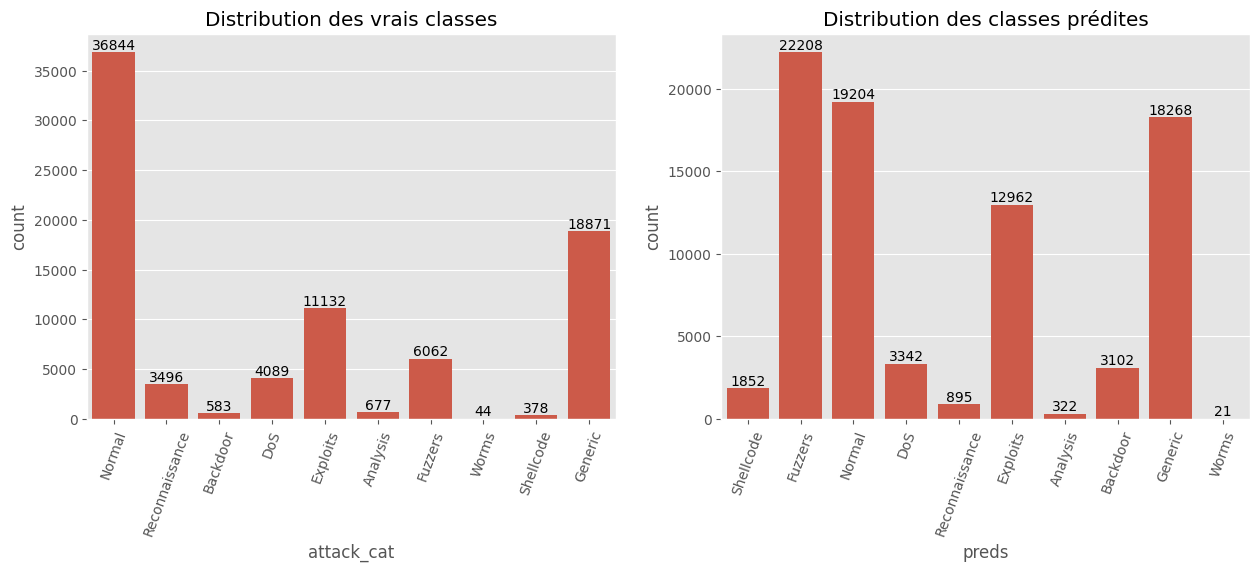

In [12]:
# Histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
ax = sns.countplot(x="attack_cat", data=test_df)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', labelrotation=70)
plt.title("Distribution des vrais classes")

plt.subplot(122)
ax = sns.countplot(x="preds", data=test_df)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', labelrotation=70)

plt.title("Distribution des classes prédites")
plt.savefig("xgb_preds.pdf", dpi=500, facecolor="w", bbox_inches="tight")
plt.show()

In [13]:
print(classification_report(test_df["attack_cat"], test_df["preds"]))

                precision    recall  f1-score   support

      Analysis       0.02      0.01      0.01       677
      Backdoor       0.03      0.17      0.05       583
           DoS       0.16      0.13      0.14      4089
      Exploits       0.55      0.64      0.59     11132
       Fuzzers       0.20      0.73      0.31      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.99      0.52      0.68     36844
Reconnaissance       0.44      0.11      0.18      3496
     Shellcode       0.09      0.44      0.15       378
         Worms       0.10      0.05      0.06        44

      accuracy                           0.61     82176
     macro avg       0.36      0.38      0.32     82176
  weighted avg       0.79      0.61      0.65     82176

